In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.1
torch 2.6.0+cpu
cpu


## 数据准备

In [2]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [3]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序（排序是为了好看）
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [5]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [6]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


### 把莎士比亚文集分成一个一个的样本

In [7]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    #text_as_int是字符的id列表，seq_length是每个样本的长度
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1 #一个样本的长度
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len #样本的个数
        
    def __getitem__(self, index):#index是样本的索引，返回的是一个样本，比如第一个，就是0-100的字符,总计101个字符
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self): #返回样本的个数
        return self.num_seq

#batch是一个列表，列表中的每一个元素是一个样本，有101个字符，前100个是输入，后100个是输出
def collat_fct(batch):
    src_list = [] #输入
    trg_list = [] #输出
    for part in batch:
        src_list.append(part[:-1]) #输入
        trg_list.append(part[1:]) #输出
        
    src_list = np.array(src_list) #把列表转换为ndarray
    trg_list = np.array(trg_list) #把列表转换为ndarray
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64) #返回的是一个元组，元组中的每一个元素是一个torch.Tensor
        
#每个样本的长度是101，也就是100个字符+1个结束符
train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

## 定义模型

In [8]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #batch_first=True,输入的数据格式是(batch_size, seq_len, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x) #(batch_size, seq_len) -> (batch_size, seq_len, embedding_dim) (64, 100, 256)
        #这里和02的差异是没有只拿最后一个输出，而是把所有的输出都拿出来了
        #(batch_size, seq_len, embedding_dim)->(batch_size, seq_len, hidden_dim)(64, 100, 1024)
        output, hidden = self.rnn(x, hidden)
        x = self.fc(output) #[bs, seq_len, hidden_dim]--->[bs, seq_len, vocab_size] (64, 100,65)
        return x, hidden #x的shape是(batch_size, seq_len, vocab_size)
    
    
vocab_size = len(vocab)

In [9]:
sample_inputs = torch.randint(0, vocab_size, (3, 100))
print(sample_inputs.shape)
model = CharRNN(vocab_size)
output=model(sample_inputs)
output[0].shape

torch.Size([3, 100])


torch.Size([3, 100, 65])

## 训练

In [10]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [11]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算,如果数据集打乱了，stateful=False，hidden就要清空
                # 如果数据集没有打乱，stateful=True，hidden就不需要清空
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失,交叉熵损失第一个参数要是二阶张量，第二个参数要是一阶张量，所以要reshape
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharRNN(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation", save_step=1000, save_best_only=True)


model = model.to(device)


In [12]:
record = training(
    model,
    train_dl,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=save_ckpt_callback,
    )

  0%|          | 0/17300 [00:00<?, ?it/s]

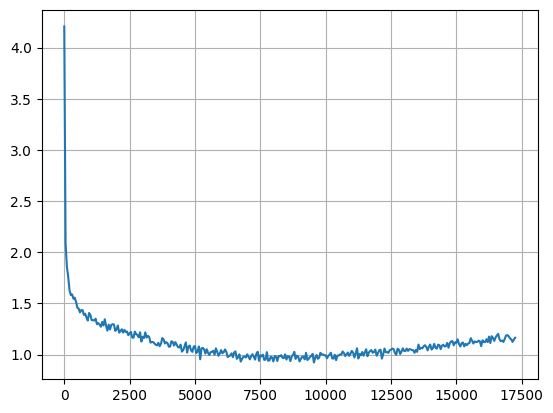

In [13]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [14]:
#说明temperature
logits = torch.tensor([400.0,600.0]) #这里是logits

probs1 = F.softmax(logits, dim=-1)
print(probs1)

tensor([0., 1.])


In [15]:
logits = torch.tensor([0.04,0.06])  #现在 temperature是2

probs1 = F.softmax(logits, dim=-1)
print(probs1)

tensor([0.4950, 0.5050])


In [16]:
import torch

# 创建一个概率分布，表示每个类别被选中的概率
# 这里我们有一个简单的四个类别的概率分布
prob_dist = torch.tensor([0.1, 0.45, 0.35, 0.1])

# 使用 multinomial 进行抽样
# num_samples 表示要抽取的样本数量
num_samples = 5

# 抽取样本，随机抽样，概率越高，抽到的概率就越高,1代表只抽取一个样本，replacement=True表示可以重复抽样
samples = torch.multinomial(prob_dist, 1, replacement=True)

print("概率分布:", prob_dist)
print("抽取的样本索引:", samples)

# 显示每个样本对应的概率
print("每个样本对应的概率:", prob_dist[samples])

概率分布: tensor([0.1000, 0.4500, 0.3500, 0.1000])
抽取的样本索引: tensor([2])
每个样本对应的概率: tensor([0.3500])


In [17]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    # 输入的字符转为id
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1) #bacth_size=1, seq_len长度是多少都可以 （1,5）
    hidden = None
    text_generated = [] #用来保存生成的文本
    model.eval()
    pbar = tqdm(range(max_len)) # 进度条
    print(start_string, end="")
    # no_grad是一个上下文管理器，用于指定在其中的代码块中不需要计算梯度。在这个区域内，不会记录梯度信息，用于在生成文本时不影响模型权重。
    with torch.no_grad():
        for i in pbar:#控制进度条
            logits, hidden = model(input_eval, hidden=hidden)
            # 温度采样，较高的温度会增加预测结果的多样性，较低的温度则更加保守。
            #取-1的目的是只要最后，拼到原有的输入上
            logits = logits[0, -1, :] / temperature #logits变为1维的
            # using multinomial to sampling
            probs = F.softmax(logits, dim=-1) #算为概率分布
            idx = torch.multinomial(probs, 1).item() #从概率分布中抽取一个样本,取概率较大的那些
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1) #把idx转为tensor
            text_generated.append(idx)
            if stream:
                print(idx2char[idx], end="", flush=True)
    return "".join([idx2char[i] for i in text_generated])


# load checkpoints
model.load_state_dict(torch.load("checkpoints/text_generation/best.ckpt", weights_only=True,map_location="cpu"))
start_string = "All: " #这里就是开头，什么都可以
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

All: we are all at once
For his strength of love
Immediate leaves thereof;
For we were here, but move me to the crown at home,
And three examples are my condure,
To watch your weapon,
That they were a man that made the sea,
To say the sun sees are like to do it, that I have to soon my mother slain I have in meeting eyes to say.

LEONTES:
Thou hast some charge that I have to speak a father,
That this shall were known to stand and lament age and beauty's hand,
Though we will command me to wear a present and stand alone,
To earn and beard,
The prettiest is all tongue of the seas
Shows that will lay me still have left an oath in hell.
Take heed, how he loves me tenderly a thousand thing to win the like a country,
To make a soldier eldest of your daughter gone, to make a sight shall seem to be more than a man and for Rome,
And I will command the slaughters and they
are with you, sir; who told me I should be oblivation; and I shall have a husband and to make thee this the best: sometime shou